In [1]:
import pandas as pd
from kipoiseq.extractors import MultiSampleVCF
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    snakemake = load_rule_args(
        snakefile = os.getcwd() + '/../Snakefile',
        rule_name = 'variant_outlier',
        root=os.getcwd() + "/.."
    )

In [3]:
df_variants = pd.read_csv(snakemake.input['prioritized'])
df_results = pd.read_csv(snakemake.input['results'])
df_genes = pd.read_csv(snakemake.input['genes'])
df_nature = pd.read_csv(snakemake.input['nature_review'])
df_wgs = pd.read_csv(snakemake.input['wgs'])
df_string = pd.read_csv(snakemake.input['string'], sep='\t').dropna()

/opt/modules/i12g/anaconda/envs/als/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (74) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_results = df_results.set_index('geneID').join(df_genes.set_index('geneID'))

In [5]:
df_variants = df_variants.rename(columns={'Gene': 'geneID', 'samples': 'sampleID'})
df_variants['sampleID'] = df_variants['sampleID'].str.replace('-', '.')
df_variants = df_variants.set_index(['geneID', 'sampleID'])

In [6]:
df_results = df_results.reset_index().set_index(['geneID', 'sampleID'])

In [7]:
df_results = df_results.join(df_variants, how='inner')

In [8]:
len(set(df_results.reset_index()['geneID']))

91

In [9]:
sum([i.startswith('CASE') for i in df_results.reset_index()['sampleID'].unique()])

58

<AxesSubplot:>

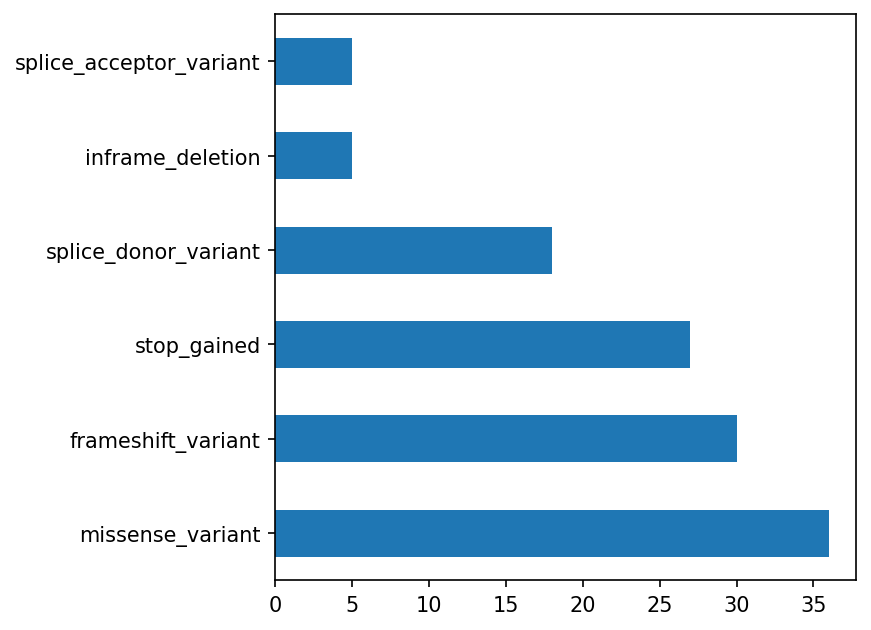

In [10]:
consequence = df_results[['Consequence']].reset_index().drop_duplicates()['Consequence'].str.split(',').str.get(0).value_counts()

plt.figure(figsize=(5, 5), dpi=150)
consequence.plot.barh()

In [11]:
df_results[df_results['gene_name'].isin(set(df_nature['gene_name']))][['gene_name', 'IMPACT', 'CLIN_SIG', 'Consequence', 'variant']]

gene_name    IMPACT           CLIN_SIG  \
geneID          sampleID                                                  
ENSG00000104133 CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11  MODERATE  likely_pathogenic   
ENSG00000123240 CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
ENSG00000137601 CASE.NEUEK191WYC      NEK1      HIGH                NaN   
                CASE.NEUEK191WYC      NEK1      HIGH                NaN   
                CASE.NEUEK191WYC      NEK1      HIGH                NaN   
                CASE.NEUEK191WYC      NEK1      HIGH                NaN   
                CASE.NEUEK191WYC      NEK1      HIGH                NaN   

                                                                        Consequence  \
geneID          sampleID                                                              
ENSG00000104133 CASE.NEUVX902YNL                               splice_donor_variant   
                CASE.NEUVX902YNL                               splice_donor_variant   
                CASE.NEUVX902YNL                               splice_donor_variant   
                CASE.NEUVX902YNL                               splice_donor_variant   
                CASE.NEUVX902YNL  splice_donor_variant,non_coding_transcript_var...   
                CASE.NEUVX902YNL            missense_variant,NMD_transcript_variant   
ENSG00000123240 CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUBK117YXL                                        stop_gained   
                CASE.NEUZT557DHF                                 frameshift_variant   
                CASE.NEUZT557DHF                                 frameshift_variant   
                CASE.NEUZT557DHF                                 frameshift_variant   
                CASE.NEUZT557DHF                                 frameshift_variant   
                CASE.NEUZT557DHF                                 frameshift_variant   
                CASE.NEUZT557DHF                                 frameshift_variant   
ENSG00000137601 CASE.NEUEK191WYC                                        stop_gained   
                CASE.NEUEK191WYC                                        stop_gained   
                CASE.NEUEK191WYC                                        stop_gain

In [12]:
df_results[df_results['gene_name'].isin(set(df_wgs['gene_name']))][['gene_name', 'IMPACT', 'CLIN_SIG', 'Consequence']]

gene_name    IMPACT           CLIN_SIG  \
geneID          sampleID                                                  
ENSG00000104133 CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11      HIGH  likely_pathogenic   
                CASE.NEUVX902YNL     SPG11  MODERATE  likely_pathogenic   
ENSG00000123240 CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUBK117YXL      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   
                CASE.NEUZT557DHF      OPTN      HIGH                NaN   

                                                                        Consequence  
geneID          sampleID                                                             
ENSG00000104133 CASE.NEUVX902YNL                               splice_donor_variant  
                CASE.NEUVX902YNL                               splice_donor_variant  
                CASE.NEUVX902YNL                               splice_donor_variant  
                CASE.NEUVX902YNL                               splice_donor_variant  
                CASE.NEUVX902YNL  splice_donor_variant,non_coding_transcript_var...  
                CASE.NEUVX902YNL            missense_variant,NMD_transcript_variant  
ENSG00000123240 CASE.NEUBK117YXL                                        stop_gained  
                CASE.NEUBK117YXL                                        stop_gained  
                CASE.NEUBK117YXL                                        stop_gained  
                CASE.NEUBK117YXL                                        stop_gained  
                CASE.NEUBK117YXL                                        stop_gained  
                CASE.NEUBK117YXL                                        stop_gained  
                CASE.NEUBK117YXL                                        stop_gained  
                CASE.NEUZT557DHF                                 frameshift_variant  
                CASE.NEUZT557DHF                                 frameshift_variant  
                CASE.NEUZT557DHF                                 frameshift_variant  
                CASE.NEUZT557DHF                                 frameshift_variant  
                CASE.NEUZT557DHF                                 frameshift_variant  
                CASE.NEUZT557DHF                                 frameshift_variant

In [69]:
df_results

pValue   padjust  zScore  l2fc  \
geneID          sampleID                                                 
ENSG00000004864 CASE.NEUCU245GBQ  9.491601e-09  0.000144   -5.98 -0.72   
                CASE.NEUCU245GBQ  9.491601e-09  0.000144   -5.98 -0.72   
ENSG00000008294 CTRL.NEUFZ500KDB  7.801855e-07  0.019286    4.73  0.35   
                CTRL.NEUFZ500KDB  7.801855e-07  0.019286    4.73  0.35   
                CTRL.NEUFZ500KDB  7.801855e-07  0.019286    4.73  0.35   
...                                        ...       ...     ...   ...   
ENSG00000215421 CTRL.NEUCV136DHM  5.476712e-06  0.011773   -4.67 -0.41   
                CTRL.NEUCV136DHM  5.476712e-06  0.011773   -4.67 -0.41   
                CTRL.NEUCV136DHM  5.476712e-06  0.011773   -4.67 -0.41   
                CTRL.NEUCV136DHM  5.476712e-06  0.011773   -4.67 -0.41   
ENSG00000237441 CASE.NEUCE965ZGK  1.042661e-07  0.009014   -5.47 -0.32   

                                  rawcounts  normcounts  meanCorrected  \
geneID          sampleID                                                 
ENSG00000004864 CASE.NEUCU245GBQ        764      724.98        1195.86   
                CASE.NEUCU245GBQ        764      724.98        1195.86   
ENSG00000008294 CTRL.NEUFZ500KDB      15724    14951.49       11760.18   
                CTRL.NEUFZ500KDB      15724    14951.49       11760.18   
                CTRL.NEUFZ500KDB      15724    14951.49       11760.18   
...                                     ...         ...            ...   
ENSG00000215421 CTRL.NEUCV136DHM       1026      845.41        1121.49   
                CTRL.NEUCV136DHM       1026      845.41        1121.49   
                CTRL.NEUCV136DHM       1026      845.41        1121.49   
                CTRL.NEUCV136DHM       1026      845.41        1121.49   
ENSG00000237441 CASE.NEUCE965ZGK       2017     2207.60        2746.96   

                                   theta  aberrant  AberrantBySample  ...  \
geneID          sampleID                                              ...   
ENSG00000004864 CASE.NEUCU245GBQ  183.17      True                20  ...   
                CASE.NEUCU245GBQ  183.17      True                20  ...   
ENSG00000008294 CTRL.NEUFZ500KDB  400.30      True                 8  ...   
                CTRL.NEUFZ500KDB  400.30      True                 8  ...   
                CTRL.NEUFZ500KDB  400.30      True                 8  ...   
...                                  ...       ...               ...  ...   
ENSG00000215421 CTRL.NEUCV136DHM  376.87      True               105  ...   
                CTRL.NEUCV136DHM  376.87      True               105  ...   
                CTRL.NEUCV136DHM  376.87      True               105  ...   
                CTRL.NEUCV136DHM  376.87      True               105  ...   
ENSG00000237441 CASE.NEUCE965ZGK  873.02      True                 4  ...   

                                  miRNA83  CADD_PHRED  CADD_RAW  \
geneID          sampleID                                          
ENSG00000004864 CASE.NEUCU245GBQ      NaN      33.000  5.044464   
                CASE.NEUCU245GBQ      NaN      33.000  5.044464   
ENSG00000008294 CTRL.NEUFZ500KDB      NaN      26.300  3.897610   
                CTRL.NEUFZ500KDB      NaN      26.300  3.897610   
                CTRL.NEUFZ500KDB      NaN      26.300  3.897610   
...                                   ...         ...       ...   
ENSG00000215421 CTRL.NEUCV136DHM      NaN       5.413  0.398804   
                CTRL.NEUCV136DHM      NaN       5.413  0.398804   
                CTRL.NEUCV136DHM      NaN       5.413  0.398804   
                CTRL.NEUCV136DHM      NaN       5.413  0.398804   
ENSG00000237441 CASE.NEUCE965ZGK      NaN      29.900  4.338119   

                                  condel_prediction  condel_score  \
geneID          sampleID                                            
ENSG00000004864 CASE.NEUCU245GBQ            neutral         0.460   
                CASE.NEUCU245GBQ 

In [70]:
df_results[df_results['CLIN_SIG'].isin({'likely_pathogenic', 'pathogenic'})][['l2fc', 'IMPACT', 'gene_name', 'variant', 'CLIN_SIG', 'Consequence']]

l2fc    IMPACT gene_name  \
geneID          sampleID                                     
ENSG00000084774 CASE.NEUBD218YR3 -0.51      HIGH       CAD   
                CASE.NEUBD218YR3 -0.51      HIGH       CAD   
                CASE.NEUBD218YR3 -0.51      HIGH       CAD   
ENSG00000101310 CASE.NEUJA217MTJ -0.45      HIGH    SEC23B   
                CASE.NEUJA217MTJ -0.45      HIGH    SEC23B   
                CASE.NEUJA217MTJ -0.45      HIGH    SEC23B   
                CASE.NEUJA217MTJ -0.45      HIGH    SEC23B   
                CASE.NEUJA217MTJ -0.45      HIGH    SEC23B   
                CASE.NEUJA217MTJ -0.45      HIGH    SEC23B   
ENSG00000104133 CASE.NEUVX902YNL -0.25      HIGH     SPG11   
                CASE.NEUVX902YNL -0.25      HIGH     SPG11   
                CASE.NEUVX902YNL -0.25      HIGH     SPG11   
                CASE.NEUVX902YNL -0.25      HIGH     SPG11   
                CASE.NEUVX902YNL -0.25      HIGH     SPG11   
                CASE.NEUVX902YNL -0.25  MODERATE     SPG11   
ENSG00000104320 CASE.NEUHM532NDD -0.69      HIGH       NBN   
                CASE.NEUHM532NDD -0.69      HIGH       NBN   
                CASE.NEUHM532NDD -0.69      HIGH       NBN   
                CASE.NEUHM532NDD -0.69      HIGH       NBN   
                CASE.NEUHM532NDD -0.69      HIGH       NBN   
ENSG00000104884 CASE.NEURR881FKY  0.47      HIGH     ERCC2   
                CASE.NEURR881FKY  0.47      HIGH     ERCC2   
                CASE.NEURR881FKY  0.47      HIGH     ERCC2   
                CASE.NEURR881FKY  0.47      HIGH     ERCC2   
                CASE.NEURR881FKY  0.47      HIGH     ERCC2   
                CASE.NEURR881FKY  0.47      HIGH     ERCC2   
ENSG00000151779 CASE.NEULY177TTN -0.52      HIGH      NBAS   
ENSG00000162129 CASE.NEUGW326BRV -0.73      HIGH      CLPB   
                CASE.NEUGW326BRV -0.73      HIGH      CLPB   
                CASE.NEUGW326BRV -0.73      HIGH      CLPB   
                CASE.NEUGW326BRV -0.73      HIGH      CLPB   
                CASE.NEUGW326BRV -0.73  MODERATE      CLPB   
                CASE.NEUGW326BRV -0.73      HIGH      CLPB   
                CASE.NEUGW326BRV -0.73      HIGH      CLPB   
ENSG00000182150 CASE.NEUTA689LN5 -0.35      HIGH   ERCC6L2   
                CASE.NEUTA689LN5 -0.35      HIGH   ERCC6L2   
                CASE.NEUTA689LN5 -0.35      HIGH   ERCC6L2   
                CASE.NEUTA689LN5 -0.35      HIGH   ERCC6L2   
                CASE.NEUTA689LN5 -0.35      HIGH   ERCC6L2   
                CASE.NEUTA689LN5 -0.35      HIGH   ERCC6L2   
                CASE.NEUTA689LN5 -0.35      HIGH   ERCC6L2   

                                                         variant  \
geneID          sampleID                                           
ENSG00000084774 CASE.NEUBD218YR3  chr2:27239368:TGCCCTTCTCCAAG>T   
                CASE.NEUBD218YR3  chr2:27239368:TGCCCTTCTCCAAG>T   
                CASE.NEUBD218YR3  chr2:27239368:TGCCCTTCTCCAAG>T   
ENSG00000101310 CASE.NEUJA217MTJ              chr20:18524980:C>T   
                CASE.NEUJA217MTJ              chr20:18524980:C>T   
                CASE.NEUJA217MTJ              chr20:18524980:C>T   
                CASE.NEUJA217MTJ              chr20:18524980:C>T   
                CASE.NEUJA217MTJ              chr20:18524980:C>T   
                CASE.NEUJA217MTJ              chr20:18524980:C>T   
ENSG00000104133 CASE.NEUVX902YNL              chr15:44620189:C>A   
                CASE.NEUVX902YNL              chr15:44620189:C>A   
                CASE.NEUVX902YNL              chr15:44620189:C>A   
                CASE.NEUVX902YNL              chr15:44620189:C>A   
                CASE.NEUVX902YNL              chr15:44620189:C>A   
                CASE.NEUVX902YNL              chr15:44620189:C>A   
ENSG00000104320 CASE.NEUHM532NDD               chr8:89984524:C>T   
                CASE.NEUHM532NDD               chr8:89984524:C>T   
                CASE.NEUHM532NDD               chr8:89984524:C>T   
       

In [14]:
df_results[df_results['gene_name'] == 'MAGED1'][['IMPACT', 'CLIN_SIG', 'Consequence']]

IMPACT CLIN_SIG       Consequence
geneID          sampleID                                             
ENSG00000179222 CASE.NEUDG000ZG5  MODERATE      NaN  missense_variant
                CASE.NEUDG000ZG5  MODERATE      NaN  missense_variant
                CASE.NEUDG000ZG5  MODERATE      NaN  missense_variant
                CASE.NEUDG000ZG5  MODERATE      NaN  missense_variant

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene2
gene1,,,,,,,,,,,
ENSG00000004059,ENSP00000000233,ENSP00000272298,0,0,332,62,181,0,125,490,ENSG00000143933
ENSG00000004059,ENSP00000000233,ENSP00000253401,0,0,0,0,186,0,56,198,ENSG00000131089
ENSG00000004059,ENSP00000000233,ENSP00000401445,0,0,0,0,159,0,0,159,ENSG00000178607
ENSG00000004059,ENSP00000000233,ENSP00000418915,0,0,0,61,158,0,542,606,ENSG00000147889
ENSG00000004059,ENSP00000000233,ENSP00000327801,0,0,0,88,78,0,89,167,ENSG00000185624
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000279408,ENSP00000485668,ENSP00000435466,0,0,0,0,0,0,155,155,ENSG00000149571
ENSG00000279408,ENSP00000485668,ENSP00000244573,0,0,0,0,0,0,173,173,ENSG00000124610
ENSG00000279408,ENSP00000485668,ENSP00000353331,0,0,0,0,0,0,167,167,ENSG00000126259


In [17]:
import pyranges as pr

df_gtf = pr.read_gtf(snakemake.input['gtf'], as_df=True)


In [23]:
df_gene_id_name = df_gtf[df_gtf.Feature == 'gene'][['gene_id', 'gene_name']].set_index('gene_name')

In [27]:
df_nature = df_nature.set_index('gene_name').join(df_gene_id_name, how='inner')

In [32]:
df_interactions = df_string[df_string['gene1'].isin(set(df_nature['gene_id']))]

In [83]:
df_interactions

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene1,gene2
536787,ENSP00000224140,ENSP00000294053,85,0,0,89,128,0,49,216,ENSG00000107290,ENSG00000162129
536788,ENSP00000224140,ENSP00000351185,0,0,0,89,0,0,122,166,ENSG00000107290,ENSG00000138346
536789,ENSP00000224140,ENSP00000418915,0,0,0,63,92,0,120,186,ENSG00000107290,ENSG00000147889
536790,ENSP00000224140,ENSP00000377969,0,0,0,183,0,0,0,183,ENSG00000107290,ENSG00000125651
536793,ENSP00000224140,ENSP00000352264,0,0,0,78,182,0,44,216,ENSG00000107290,ENSG00000198087
...,...,...,...,...,...,...,...,...,...,...,...,...
11640832,ENSP00000482753,ENSP00000389414,0,0,0,0,0,0,226,226,ENSG00000147894,ENSG00000059377
11640833,ENSP00000482753,ENSP00000304292,0,0,0,0,0,0,277,277,ENSG00000147894,ENSG00000105186
11640834,ENSP00000482753,ENSP00000354791,0,0,0,0,0,0,640,640,ENSG00000147894,ENSG00000204843
11640835,ENSP00000482753,ENSP00000360108,0,0,0,63,0,0,145,164,ENSG00000147894,ENSG00000116675


<AxesSubplot:>

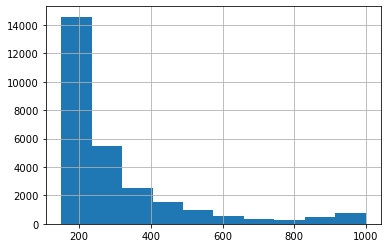

In [90]:
df_interactions['combined_score'].hist()

In [95]:
interacting_genes = set(df_interactions[df_interactions['combined_score'] > 800]['gene2'])
interacting_genes = interacting_genes.intersection(df_results.reset_index()['geneID'])

In [100]:
interacting_genes

{'ENSG00000057608',
 'ENSG00000104884',
 'ENSG00000106052',
 'ENSG00000115020',
 'ENSG00000123240',
 'ENSG00000145782'}

In [108]:
for i in set(df_results[df_results['geneID'].isin(interacting_genes)]['gene_name']):
    print(i)

GDI2
OPTN
ATG12
PIKFYVE
ERCC2
TAX1BP1


In [113]:
for i in set(df_nature.index):
    print(i)

VAPB
TARDBP
OPTN
UNC13A
HNRNPA2B1
UBQLN2
SETX
SIGMAR1
SPG11
ANG
C9orf72
TBK1
TAF15
NEK1
ELP3
FIG4
FUS
HNRNPA1
C21orf2
ATXN2
ALS2
MATR3
SOD1
CHCHD10
SQSTM1
CHMP2B


In [104]:
df_results = df_results.reset_index()
for i in set(df_results[df_results['geneID'].isin(interacting_genes)]['gene_name']):
    print(i)

ValueError: cannot insert level_0, already exists

In [76]:
df_prof = pd.read_csv('/data/nasif12/home_if12/celikm/Projects/ALS/data/processed/networkanalysis/prob_of_reaching_gene_from_seeds.tsv', sep='\t')

<AxesSubplot:>

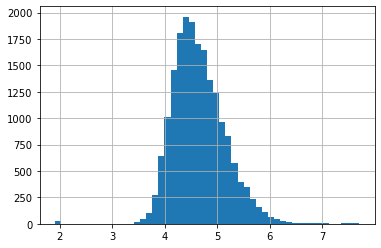

In [82]:
import numpy as np

(-np.log10(df_prof['score'])).hist(bins=50)

In [139]:
-np.log10(0.0001)

4.0

In [136]:
df_sig = df_prof[-np.log10(df_prof['score']) < 4]

In [137]:
for i in set(df_results.set_index('geneID').join(df_sig.set_index('gene_id'), how='inner')['gene_name']):
    print(i)

SPG11
UQCRC1
HSPA4
OPTN
PIKFYVE
TUFM
IMMT
NEK1
CLPB
PARP1
UBQLN4


In [138]:
df_results = df_results.reset_index()

ValueError: cannot insert level_0, already exists

In [62]:
df_interactions

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score,gene1,gene2
536787,ENSP00000224140,ENSP00000294053,85,0,0,89,128,0,49,216,ENSG00000107290,ENSG00000162129
536788,ENSP00000224140,ENSP00000351185,0,0,0,89,0,0,122,166,ENSG00000107290,ENSG00000138346
536789,ENSP00000224140,ENSP00000418915,0,0,0,63,92,0,120,186,ENSG00000107290,ENSG00000147889
536790,ENSP00000224140,ENSP00000377969,0,0,0,183,0,0,0,183,ENSG00000107290,ENSG00000125651
536793,ENSP00000224140,ENSP00000352264,0,0,0,78,182,0,44,216,ENSG00000107290,ENSG00000198087
...,...,...,...,...,...,...,...,...,...,...,...,...
11640832,ENSP00000482753,ENSP00000389414,0,0,0,0,0,0,226,226,ENSG00000147894,ENSG00000059377
11640833,ENSP00000482753,ENSP00000304292,0,0,0,0,0,0,277,277,ENSG00000147894,ENSG00000105186
11640834,ENSP00000482753,ENSP00000354791,0,0,0,0,0,0,640,640,ENSG00000147894,ENSG00000204843
11640835,ENSP00000482753,ENSP00000360108,0,0,0,63,0,0,145,164,ENSG00000147894,ENSG00000116675
